In [ ]:
!pip install rasterio

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/speckle_filtering')

In [5]:
from DatasetHandler import DatasetHandler
from Model import CNNSpeckleFilter
from utils import *

# Load the dataset

In [6]:
handler = DatasetHandler('/content/drive/MyDrive/speckle_filtering/dataset')
print("Training dataset size: ", len(handler.train_paths))
print("Validation dataset size: ", len(handler.val_paths))
print("Testing dataset size: ", len(handler.test_paths))

Training dataset size:  2000
Validation dataset size:  600
Testing dataset size:  37


In [7]:
compute_max_min = False

if compute_max_min:
  MAX, MIN = handler.getstats(handler.train_paths)
else:
  MAX = 29968.252
  MIN = 0

print('Dataset max: ', MAX, 'Dataset min: ', MIN)

Dataset max:  29968.252 Dataset min:  0


In [8]:
IMG_SHAPE = (96,96,1)

In [63]:
batch_speckle, batch_clean, batch_noise = next(iter(handler.data_loader(
    paths      = handler.train_paths, 
    batch_size = 1, 
    img_shape  = IMG_SHAPE,
    MAX = MAX,
    MIN = MIN,
    out_noise = True)
))

a
0.00011070613254560158
a
0.0002951998640250178


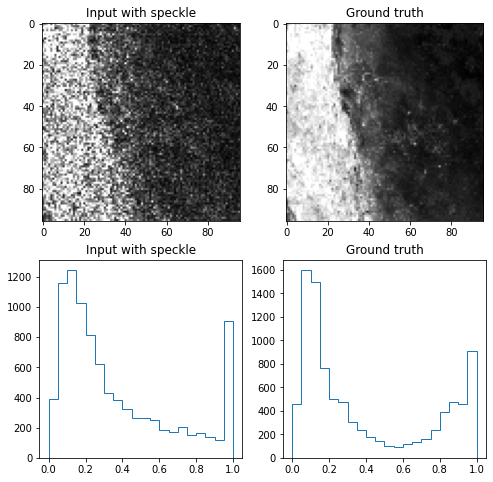

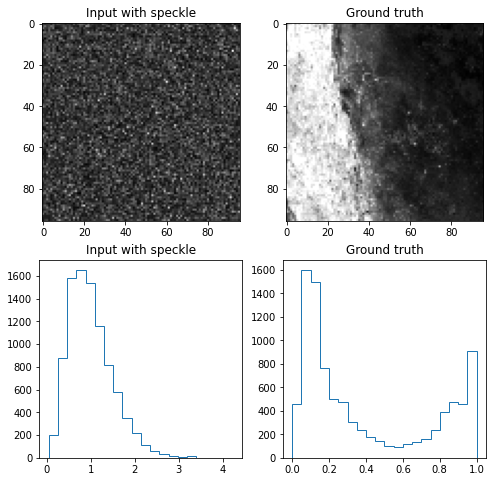

In [64]:
plot_dataset(batch_speckle, batch_clean)
plot_dataset(batch_noise, batch_clean)

# CNN speckle filter training

## Intialize the model


In [65]:
TRAIN = True

N_LAYER = 12
speckle_filter = CNNSpeckleFilter(input_shape=IMG_SHAPE, n_layers=N_LAYER)
#speckle_filter.model.summary()

if TRAIN:
    epochs = 60
    batch_size = 16

    train_gen = handler.data_loader(
        paths      = handler.train_paths, 
        batch_size = batch_size, 
        img_shape  = IMG_SHAPE,
        MAX = MAX,
        MIN = MIN,
        out_noise = False)

    val_gen = handler.data_loader(
        paths      = handler.val_paths, 
        batch_size = batch_size, 
        img_shape  = IMG_SHAPE,
        MAX = MAX,
        MIN = MIN,
        out_noise = False)

    train_step = len(handler.train_paths)//batch_size
    val_step = len(handler.val_paths)//batch_size

    history = speckle_filter.train_model(epochs, train_gen, val_gen, train_step, val_step)
    speckle_filter.model.save('/content/drive/MyDrive/speckle_filtering/trained_weights/new_model_'+str(N_LAYER)+'layers_relu.h5')

    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
    axes[0].plot(history.history['loss'], label = 'Training')
    axes[0].plot(history.history['val_loss'], label = 'Validation')
    axes[0].legend()

    axes[1].plot(history.history['mae'], label = 'Training')
    axes[1].plot(history.history['val_mae'], label = 'Validation')
    axes[1].legend()
else:
    from tensorflow.keras.models import load_model
    speckle_filter.model = load_model('/content/drive/MyDrive/speckle_filtering/trained_weights/new_model_'+str(N_LAYER)+'layers.h5')

Epoch 1/60
125/125 [==============================] - 547s 4s/step - loss: 0.0402 - mae: 0.1412 - val_loss: 0.0342 - val_mae: 0.1288
Epoch 2/60
125/125 [==============================] - 214s 2s/step - loss: 0.0359 - mae: 0.1332 - val_loss: 0.0358 - val_mae: 0.1326
Epoch 3/60
125/125 [==============================] - 118s 949ms/step - loss: 0.0355 - mae: 0.1323 - val_loss: 0.0353 - val_mae: 0.1322
Epoch 4/60
125/125 [==============================] - 82s 659ms/step - loss: 0.0357 - mae: 0.1329 - val_loss: 0.0365 - val_mae: 0.1350
Epoch 5/60
125/125 [==============================] - 66s 533ms/step - loss: 0.0355 - mae: 0.1318 - val_loss: 0.0352 - val_mae: 0.1314
Epoch 6/60
125/125 [==============================] - 61s 494ms/step - loss: 0.0353 - mae: 0.1318 - val_loss: 0.0364 - val_mae: 0.1354
Epoch 7/60
125/125 [==============================] - 60s 480ms/step - loss: 0.0354 - mae: 0.1320 - val_loss: 0.0370 - val_mae: 0.1366
Epoch 8/60
 30/125 [======>.......................] - ETA:

KeyboardInterrupt: ignored

In [ ]:
#speckle_filter.model.save('/content/drive/MyDrive/speckle_filtering/trained_weights/new_model_'+str(N_LAYER)+'layers.h5')

In [67]:
batch_speckle, batch_clean = handler.data_loader_v2(
    paths      = handler.test_paths, 
    img_shape  = IMG_SHAPE,
    MAX = MAX,
    MIN = MIN)

batch_pred = speckle_filter.model.predict(batch_speckle)

In [ ]:
for i in range(batch_pred.shape[0]):
  batch_pred[i,...] = (batch_pred[i,...] - np.min(batch_pred[i,...]))/(np.max(batch_pred[i,...])-np.min(batch_pred[i,...]))     

In [ ]:
plot_model_results(batch_speckle, batch_clean, batch_pred, n=True)

In [ ]:
compute_metrics(batch_speckle, batch_clean, batch_pred)

# Compare results
1. Install modules

In [ ]:
!git clone https://github.com/cszn/DPIR.git
!git clone https://github.com/k-radlak/IDCNN.git
!git clone https://github.com/grip-unina/SAR-CNN.git

In [ ]:
import sys
sys.path.append('DPIR')
sys.path.append('DPIR/utils')
sys.path.append('DPIR/models')

sys.path.append('SAR-CNN')
sys.path.append('SAR-CNN/models')

sys.path.append('IDCNN')

## Load IDCNN

In [ ]:
import torch
device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from network_unet import UNetRes as net
idcnn = net(in_nc=2, out_nc=1, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
idcnn.load_state_dict(torch.load('other_weights/drunet_gray.pth'), strict=True)
idcnn.eval()
for k, v in idcnn.named_parameters():
    v.requires_grad = False
idcnn = idcnn.to(device)

## Load SAR-CNN/DnCNN

In [ ]:
import DnCNN as DnCNN
import pickle

def preprocessing_int2net(img):
    return img.abs().log()/2

def postprocessing_net2int(img):
    return (2*img).exp()

with open('other_weights/SAR_CNN_e50.pkl', "rb") as fid:
    dncnn_opt = dict(**pickle.load(fid).dncnn)
    dncnn_opt["residual"] = True
sarcnn = DnCNN.DnCNN(1, 1, **dncnn_opt)
sarcnn.load_state_dict(torch.load('other_weights/SAR_CNN_e50.t7', map_location=torch.device('cpu'))['net'])

In [ ]:
from findpeaks import findpeaks
import findpeaks
import bm3d
import matplotlib

In [ ]:
def single2tensor4(img):
      return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float().unsqueeze(0)

def apply_filters(clean, speckle, filter):
    # filters parameters
    # window size
    winsize = 3
    # damping factor for frost
    k_value1 = 2.0
    # damping factor for lee enhanced
    k_value2 = 1.0
    # coefficient of variation of noise
    cu_value = 0.25
    # coefficient of variation for lee enhanced of noise
    cu_lee_enhanced = 0.523
    # max coefficient of variation for lee enhanced
    cmax_value = 1.73

    img = findpeaks.stats.scale(speckle[...,0])

    # Classic
    image_lee = findpeaks.lee_filter(img, win_size=winsize, cu=cu_value)
    image_lee_enhanced = findpeaks.lee_enhanced_filter(img, win_size=winsize, k=k_value2, cu=cu_lee_enhanced, cmax=cmax_value)
    image_kuan = findpeaks.kuan_filter(img, win_size=winsize, cu=cu_value)
    image_frost = findpeaks.frost_filter(img, damping_factor=k_value1, win_size=winsize)
    image_mean = findpeaks.mean_filter(img.copy(), win_size=winsize)
    image_median = findpeaks.median_filter(img, win_size=winsize)
    img_fastnl = findpeaks.stats.denoise(img, method='fastnl', window=winsize)
    img_bilateral = findpeaks.stats.denoise(img, method='bilateral', window=winsize)

    # BM3D
    img_bm3d = bm3d.bm3d(speckle[...,0], sigma_psd=30/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

    # IDCNN
    matplotlib.image.imsave('test/test.png', img, cmap='gray')  
    !python IDCNN/inference.py --test_file test/test.png --checkpoint_dir IDCNN/results/checkpoint_impulses_bsd500_41/ --save_dir test/ --phase inference
    img_L = single2tensor4(speckle[0:64,0:64,...])
    img_L = torch.cat((img_L, torch.FloatTensor([15/255.]).repeat(1, 1, img_L.shape[2], img_L.shape[3])), dim=1)
    img_L = img_L.to(device)
    res = idcnn(torch.FloatTensor(img_L)).detach().numpy()
    IDCNN = plt.imread('test/denoised_CNN_test.png')
    IDCNN = IDCNN[...,1]



    # SARCNN
    with torch.no_grad():
        target_amp = torch.from_numpy((1+clean[0:64,0:64]).astype(np.float32))[None, None, :, :]
        randomStream = np.random.RandomState(32)
        noise_int    = randomStream.gamma(size=(64,64), shape=1.0, scale=1.0)
        noise_int  = torch.from_numpy(noise_int.astype(np.float32))[None, None, :, :]

        noisy_int  = (target_amp**2)*noise_int
        noisy_int = preprocessing_int2net(noisy_int)
        pred_int = sarcnn(noisy_int)

        pred_int = postprocessing_net2int(pred_int)
        pred_int = pred_int.detach().numpy()    
        pred_int = (pred_int - pred_int.min())/((pred_int.max() - pred_int.min()) + 1e-6)


    imgs = []
    imgs.append(clean[0:64,0:64])
    imgs.append(speckle[0:64,0:64,0])
    imgs.append(filter[0:64,0:64])
    imgs.append(image_lee[0:64,0:64])
    imgs.append(image_lee_enhanced[0:64,0:64])
    imgs.append(image_kuan[0:64,0:64])
    imgs.append(image_frost[0:64,0:64])
    imgs.append(image_mean[0:64,0:64])
    imgs.append(image_median[0:64,0:64])
    imgs.append(img_fastnl[0:64,0:64])
    imgs.append(img_bilateral[0:64,0:64])
    imgs.append(img_bm3d[0:64,0:64])
    imgs.append(res[0,0,...])
    imgs.append(IDCNN[0:64,0:64])
    imgs.append(pred_int[0,0,...])

    return imgs

In [ ]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

def compute_metrics_2(speckle, clean, filter, name):

  if filter.max()>30:
    filter = filter/255.0

  gt_vs_in  = peak_signal_noise_ratio(clean, speckle, data_range=1.0)
  gt_vs_pred  = peak_signal_noise_ratio(clean, filter, data_range=1.0)

  print('|PSRN(GT VS SPECKLE): %.2f\tPSNR(GT VS FILTER): %.2f\t |%s' % (gt_vs_in, gt_vs_pred, name))
  
  gt_vs_in  = structural_similarity(clean, speckle, data_range=1.0)
  gt_vs_pred  = structural_similarity(clean, filter, data_range=1.0)
  
  print('|SSIM(GT VS SPECKLE): %.2f\tSSIM(GT VS FILTER): %.2f\t |%s' % (gt_vs_in, gt_vs_pred, name))
  print('|----------------------------------------------------------------|')


In [ ]:
for IMG_N in range(batch_speckle.shape[0]):

  #batch_speckle, batch_clean, batch_pred
  #IMG_N = 3
  
  imgs = apply_filters(batch_clean[IMG_N,...,0], batch_speckle[IMG_N,...], batch_pred[IMG_N,...,0])
  labels = ['Ground Truth','Input With Speckle','Proposed', 'Lee', 'Lee Enhanced', 'Kuan', 'Frost', 'Mean', 'Median', 'Fastnl', 'Bilateral', 'BM3D', 'DnCNN', 'ID-CNN', 'SAR-CNN']

  print('|----------------------------------------------------------------|')
  fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (24,18))

  counter = 0
  for i in range(4):
    for j in range(4):
      try:
        axes[i,j].imshow(imgs[counter], cmap = 'gray')

        axes[i,j].set_title(labels[counter], fontsize = 18)
        compute_metrics_2(batch_speckle[IMG_N,:64,:64,0], batch_clean[IMG_N,:64,:64,0], imgs[counter], labels[counter])
        #compute_metrics_3(batch_speckle[IMG_INDX,...,0], imgs[counter], labels[counter])
        axes[i,j].axis(False)
      except:
        axes[i,j].imshow(np.zeros((64,64)), cmap = 'gray')
        axes[i,j].axis(False)
      counter += 1

  plt.show()